In [1]:
#Import the libraries
import numpy as np
import pandas as pd

import pickle

import warnings
warnings.filterwarnings("ignore")

## SARIMAX

In [2]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

### Training BKK with *minimal_SARIMAX*

In [3]:
import sys
sys.path.append('../')

In [4]:
from importlib import reload

from custom_function import minimalSARIMAX

reload(minimalSARIMAX)

from custom_function.minimalSARIMAX import MinimalSARIMAX

In [5]:
train_set = pd.read_csv('6Hsampled_data_set/BKK/train_set.csv')
train_set['WindDirSin'] = np.sin(train_set['WindDir'])*10 + 10
train_set['WindDirCos'] = np.cos(train_set['WindDir'])*10 + 10
train_set['Time'] = pd.to_datetime(train_set['Time'])
train_set = train_set.set_index('Time')

valid_set = pd.read_csv('6Hsampled_data_set/BKK/valid_set.csv')
valid_set['WindDirSin'] = np.sin(valid_set['WindDir'])*10 + 10
valid_set['WindDirCos'] = np.cos(valid_set['WindDir'])*10 + 10
valid_set['Time'] = pd.to_datetime(valid_set['Time'])
valid_set = valid_set.set_index('Time')

test_set = pd.read_csv('6Hsampled_data_set/BKK/test_set.csv')
test_set['WindDirSin'] = np.sin(test_set['WindDir'])*10 + 10
test_set['WindDirCos'] = np.cos(test_set['WindDir'])*10 + 10
test_set['Time'] = pd.to_datetime(test_set['Time'])
test_set = test_set.set_index('Time')

##### Tuning Parameters

In [6]:
order = (2, 0, 2)
seasonal_order = (1, 1, 1, 1461)

exog_order = {}
exog_order['Temp'] = (2, 0, 1)
exog_order['WindSpeed'] = (2, 0, 2)
exog_order['WindDirSin'] = (0, 1, 1)
exog_order['WindDirCos'] = (2, 0, 0)

exog_seasonal_order = {}
exog_seasonal_order['Temp'] = (1, 0, 0, 1461)
exog_seasonal_order['WindSpeed'] = (0, 0, 1, 1461)
exog_seasonal_order['WindDirSin'] = (1, 0, 1, 1461)
exog_seasonal_order['WindDirCos'] = (0, 1, 1, 1461)

exog_columns = ['Temp', 'WindSpeed', 'WindDirSin', 'WindDirCos']

In [7]:
model = {}
model_exog = {}

model = MinimalSARIMAX(train_set[['PM25']],
                          order,
                          seasonal_order,
                          exog=train_set[exog_columns])
model.fit(lr=1e-6, lr_decay=0.999 ,verbose=0)
    
model_exog = {}
for exog in exog_columns:
    model_exog[exog] = MinimalSARIMAX(train_set[[exog]],
                                      exog_order[exog],
                                      exog_seasonal_order[exog])

In [8]:
model.fit(lr=1e-6, lr_decay=0.999 ,verbose=0)

for exog in exog_columns:
        model_exog[exog].fit(lr=1e-6, lr_decay=0.999, verbose=0)
        _ = model_exog[exog].predict_step(train_set[[exog]],
                                          valid_set[[exog]], 
                                          lr=np.array([1e-6]), lr_decay=0.999875, lr_decay_iter=0.95,
                                          step=12, n_iter=1, learn=True, verbose=1)

100%|██████████| 4383/4383 [04:03<00:00, 18.00it/s]


ITER#0  RMSE:4.252850319383202


100%|██████████| 4383/4383 [04:30<00:00, 16.23it/s]


ITER#0  RMSE:9.19566451400447


100%|██████████| 4383/4383 [04:35<00:00, 15.89it/s]


ITER#0  RMSE:11.310198919233684


100%|██████████| 4383/4383 [04:50<00:00, 15.07it/s]

ITER#0  RMSE:10.175099021252874


#### Bangkok

In [9]:
Result_train = model.predict_step(train_set[['PM25']],
                                  valid_set[['PM25']], 
                                  val_X_exog=train_set[exog_columns],
                                  y_exog=valid_set[exog_columns], 
                                  model_exog=model_exog,
                                  lr=np.array([5e-6, 5e-7, 5e-7, 5e-7, 5e-7]), lr_decay=0.999, lr_decay_iter=0.95,
                                  step=12, n_iter=10, learn=True, verbose=1)

train_pred_sav, val1_pred_sav, Error_save = Result_train

100%|██████████| 4383/4383 [18:40<00:00,  3.91it/s]


ITER#0  RMSE:12.232054817763597


100%|██████████| 4383/4383 [18:14<00:00,  4.00it/s]


ITER#1  RMSE:11.705433144277


100%|██████████| 4383/4383 [18:12<00:00,  4.01it/s]


ITER#2  RMSE:10.842645454762664


100%|██████████| 4383/4383 [17:28<00:00,  4.18it/s]


ITER#3  RMSE:9.982492364960436


100%|██████████| 4383/4383 [18:26<00:00,  3.96it/s]


ITER#4  RMSE:9.36312152780895


100%|██████████| 4383/4383 [17:39<00:00,  4.14it/s]


ITER#5  RMSE:9.127156007819224


100%|██████████| 4383/4383 [17:00<00:00,  4.29it/s]


ITER#6  RMSE:9.108643699503272


100%|██████████| 4383/4383 [16:47<00:00,  4.35it/s]


ITER#7  RMSE:9.12980317484176


100%|██████████| 4383/4383 [16:08<00:00,  4.53it/s]


ITER#8  RMSE:9.14029794037309


100%|██████████| 4383/4383 [15:04<00:00,  4.85it/s]

ITER#9  RMSE:9.143315252642905


In [10]:
model.params

{'p': array([0.47977822, 0.47730132]),
 'pX': array([ 0.04141684, -0.01843033, -0.01293386,  0.01530982]),
 'd': array([0.]),
 'q': array([0.22743622, 0.23949206]),
 'P': array([0.04220358]),
 'D': array([-0.01921806]),
 'Q': array([0.05339288]),
 'c': 0.02139187569697782}

In [11]:
with open('../model_save/model_bkk.model',"wb") as f:
    pickle.dump(model, f)

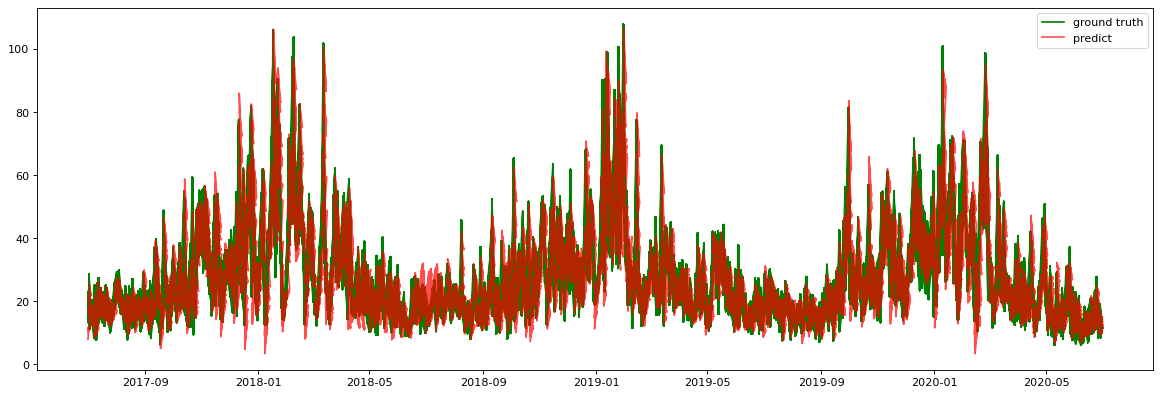

In [12]:
train_X = pd.concat([train_pred_sav, val1_pred_sav])
train_X = train_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_X['Actual'], color='g', label='ground truth')
plt.plot(train_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [13]:
Result_test = model.predict_step(valid_set[['PM25']],
                                 test_set[['PM25']], 
                                 val_X_exog=valid_set[exog_columns],
                                 y_exog=test_set[exog_columns], 
                                 model_exog=model_exog,
                                 lr=np.array([5e-7, 5e-7, 5e-7, 5e-7, 5e-7]), lr_decay=0.999875,
                                 step=12, n_iter=1, learn=True, verbose=1)	

val2_pred_sav, test_pred_sav, Error_save = Result_test

100%|██████████| 2779/2779 [08:41<00:00,  5.33it/s]

ITER#0  RMSE:7.172592822599887


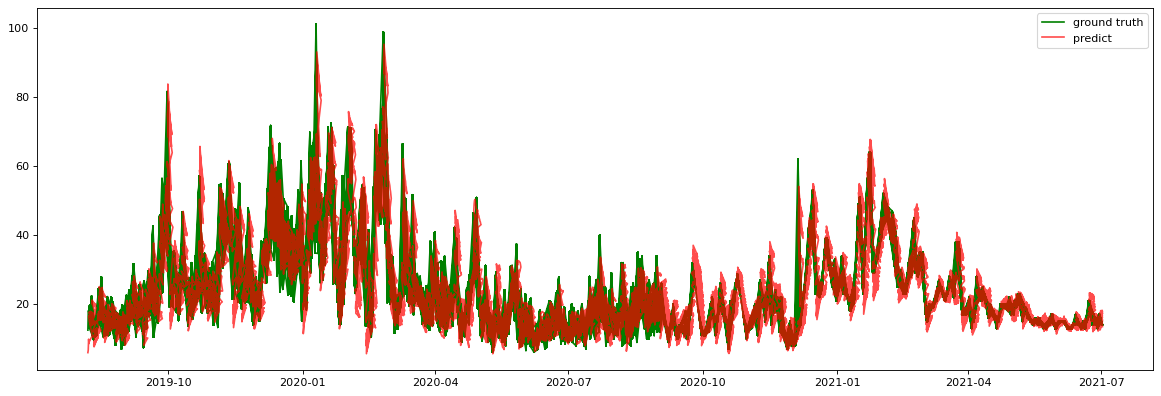

In [16]:
test_X = pd.concat([val2_pred_sav, test_pred_sav])
test_X = test_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test_X['Actual'], color='g', label='ground truth')
plt.plot(test_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [15]:
test_pred_sav.to_csv('../answer_dataset/pred_and_actual/y_pred_sav_BKK.csv')